# Phosphorus Machine Learning Project

### See `utils.py` for the bones of the code.

### This notebook is exclusively for visualization.

In [1]:
import utils
from utils import *

from importlib import reload
# to reload utils, run:
utils = reload(utils)
from utils import *

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

## Read in Data

In [3]:
ROOTDIR = Path()

CIDdir = ROOTDIR/"ProcessedData"
Listdir = ROOTDIR/"Categories"

X_data = get_Data(Listdir)

XANES_energies = X_data[0]['XANES_Spectra'][0]
XES_energies = X_data[0]['XES_Spectra'][0]

### Create dictionary maps for each CID based on different codes

In [4]:
X_data_classed = [c for c in X_data if c['Class']!='None']
compoundmap = {compound['CID']:compound for compound in X_data_classed}

CIDs = np.array([c['CID'] for c in X_data_classed])
NoneCIDs = np.array([c['CID'] for c in X_data if c['Class']=='None'])

make_SI_figures = True

# CLASSSIFICATION MAPS
# classes
classcodemap = {compound['CID']:CLASSCODES[compound['Class']] for compound in X_data_classed
                if compound['Class'] in CLASSCODES.keys()}
classnames = list(CLASSCODES.keys())[:-1]

# coordination
coordcodemap = {compound['CID']:COORDCODES[compound['Class']] for compound in X_data_classed
                if compound['Class'] in COORDCODES.keys()}

# sulfur subclasses
sulfurcodemap = {compound['CID']:SULFURCODES[compound['Class']] for compound in X_data_classed
                 if compound['Class'] in SULFURCODES.keys()}

# OH subclasses
ohcodemap = {compound['CID']:OHCODES[compound['Class']] for compound in X_data_classed
                 if compound['Class'] in OHCODES.keys()}

# chargemap
chargemap = {compound['CID']:compound['Charge'] for compound in X_data_classed}

#### Coordination

* How does tricoordinate versus tetracoordinate compare?

In [8]:
X_coord, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, coordcodemap, mode='XES',
                                                             method='UMAP')
X_coord, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, coordcodemap, mode='XANES',
                                                                 method='UMAP')

## PCA

VtC-XES takes 7 PCs to explain 0.9502 variance
XANES takes 14 PCs to explain 0.9506 variance


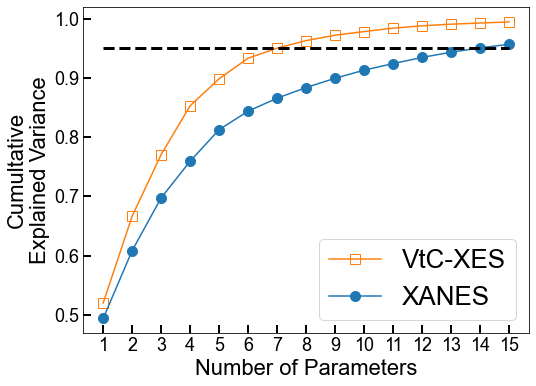

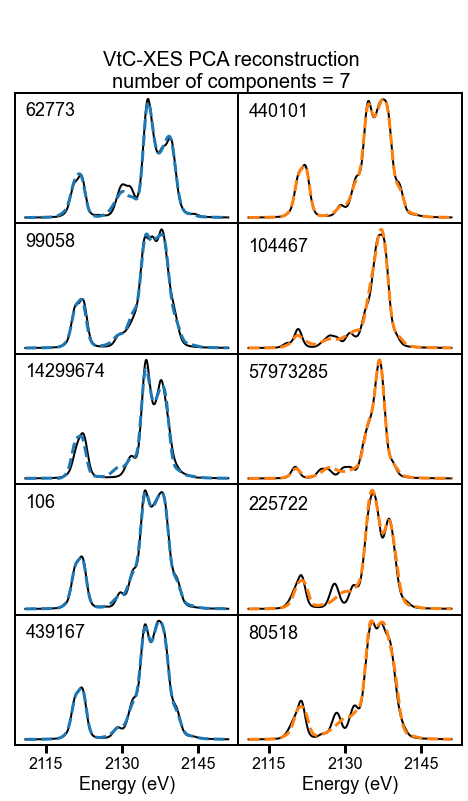

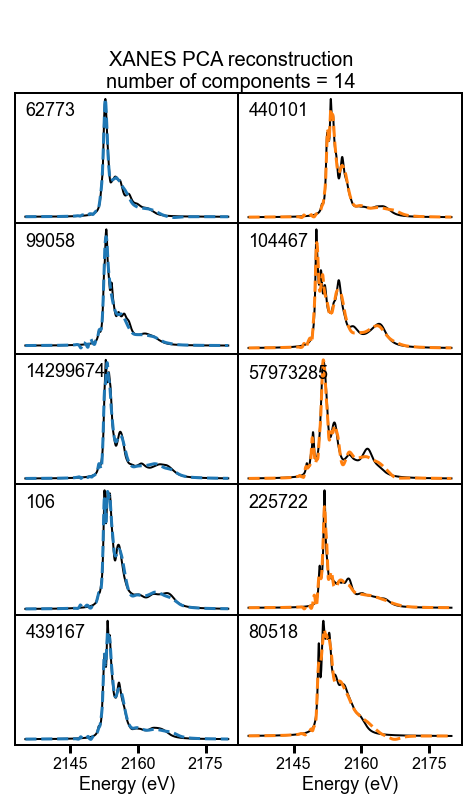

In [6]:
### Reconstrcution figure
if make_SI_figures:
    XES = np.array([c['XES_Normalized'] for c in X_coord])
    XANES = np.array([c['XANES_Normalized'] for c in X_coord])

    # pca
    pca_all_xes = PCA()
    XES_PCA = pca_all_xes.fit_transform(XES)
    pca_all_xanes = PCA()
    XANES_PCA = pca_all_xanes.fit_transform(XANES)

    N = XANES_PCA.shape[1]

    explained_var_xes = np.array([np.sum(pca_all_xes.explained_variance_ratio_[:i+1]) for i in range(N)])
    explained_var_xanes = np.array([np.sum(pca_all_xanes.explained_variance_ratio_[:i+1]) for i in range(N)])

    threshold_xes = np.where(explained_var_xes >= 0.95)[0][0]
    threshold_xanes = np.where(explained_var_xanes >= 0.95)[0][0]

    print(f"VtC-XES takes {threshold_xes+1} PCs to explain {explained_var_xes[threshold_xes]:.04f} variance")
    print(f"XANES takes {threshold_xanes+1} PCs to explain {explained_var_xanes[threshold_xanes]:.04f} variance")
    
    make_stacked_scree(pca_all_xes.explained_variance_ratio_, pca_all_xanes.explained_variance_ratio_, n=15)
    
    for mode in ['XES', 'XANES']:
        if mode == 'XES':
            n_components = threshold_xes + 1
            SPECTRA = XES
        else:
            n_components = threshold_xanes + 1
            SPECTRA = XANES
    
        pca = PCA(n_components=n_components)
        pca = pca.fit(SPECTRA)  
        x = X_coord[0][f'{mode}_Spectra'][0]

        fig = plt.figure(figsize=(8, 12))
        n = 10
        spec = fig.add_gridspec(nrows=n//2, ncols=2)
        plt.subplots_adjust(wspace=0, hspace=0)

        for counter, index in enumerate(np.arange(0,400,400//n)):
            row = counter%(n//2)
            colm = int(counter//(n/2))
            ax = fig.add_subplot(spec[row, colm])
            
            cid = X_coord[index]['CID']
            true = [SPECTRA[index]]
            recon = pca.inverse_transform(pca.transform(true))
            true = np.array(true).reshape(-1)
            
            plt.plot(x, true, 'k-', linewidth=2)
            plt.plot(x, recon.reshape(-1), '--', c=plt.cm.tab20(colm*2), linewidth=3)
            
            set_spine_width(ax, width=2)
            ax.set_yticks([])
            t = ax.text(np.min(x), np.max(true) - 0.1*np.max(true),
                        cid, ha="left", va="center", size=18)
            
            if row == int(n//2) - 1:
                ax.set_xlabel('Energy (eV)', fontsize=18)
                ax.xaxis.set_major_locator(MultipleLocator(15))
                ax.set_xticklabels(np.array(ax.get_xticks(), dtype=int), fontsize=16)
                ax.tick_params(direction='out', width=3, length=8, which='major')
            else:
                ax.set_xticks([])
                ax.set_xlabel(None)
        
        if mode == 'XES':
            mode = 'VtC-' + mode
        
        fig.suptitle(f'\n\n{mode} PCA reconstruction\nnumber of components = {n_components}', fontsize=20)
    
#         plt.savefig(f'../Figures/PCA_recon_{mode}.png', dpi=800, transparent=True, bbox_inches='tight')

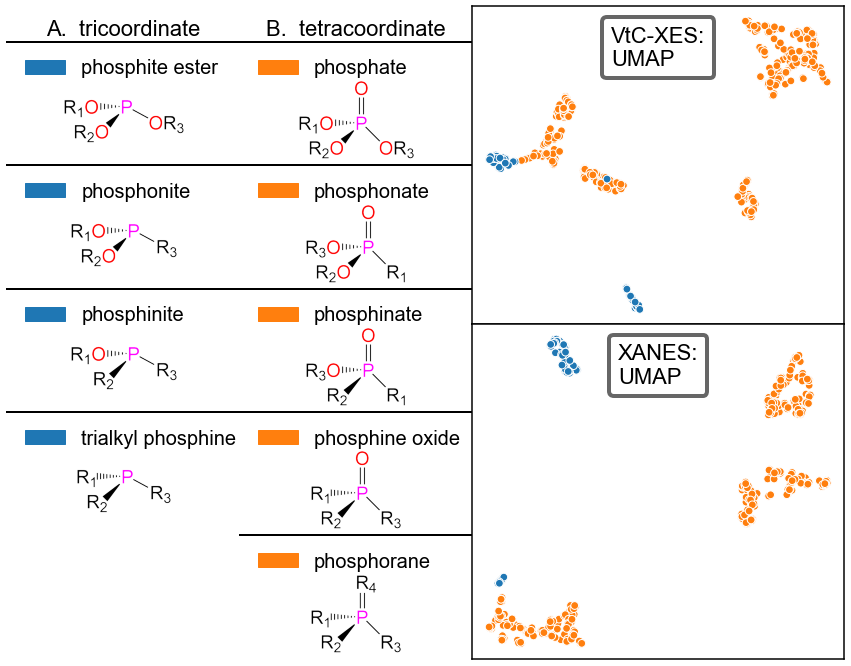

In [9]:
fig = plt.figure(figsize=(15,12))
asize = 0.4
spec = fig.add_gridspec(nrows=11, ncols=3,
                        width_ratios = [0.5, 0.5, 0.8],
                        height_ratios=[asize, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0., hspace=0)

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate', 'B.  tetracoordinate']

colorcode, codemap = COORDCODES, coordcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # show structure
        structax = fig.add_subplot(spec[2*i + 2,j])
        if j == 0:
            structure = resize_img(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        plt.axis('equal')
        # Hide spines
        set_spine_width(structax, width=2)
        turn_off_spines(structax, spines=['top','left','right'])
        if i == len(structure_list) - 1:
            structax.spines['bottom'].set_visible(False)
        turn_off_ticks(structax)

        # make legend
        legax = fig.add_subplot(spec[2*i + 1,j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(0., 0.25),
                              fontsize=20, framealpha=0, frameon=False)
        # Hide spines
        set_spine_width(legax, width=2)
        turn_off_spines(legax, spines=['bottom','left','right'])
        turn_off_ticks(legax)
        
        if i == 0:
            legax.set_title(titles[j], fontsize=22)
            
ax = fig.add_subplot(spec[:6,2])
class_tsneplt = plot_dim_red((fig, ax), X_coord, XES_tsnemap, colorcodemap=codemap,
                              mode='XES', method='UMAP', hiddencids=hiddenCIDS, fontsize=22,
                              size=60, edgecolors='w', **{'loc': 'upper center'})
set_spine_width(ax, width=1.5)

ax = fig.add_subplot(spec[6:11,2])
class_tsneplt = plot_dim_red((fig, ax), X_coord, XANES_tsnemap, colorcodemap=codemap,
                              mode='XANES', method='UMAP', hiddencids=hiddenCIDS, fontsize=22,
                              size=60, edgecolors='w', **{'loc': 'upper center'})
set_spine_width(ax, width=1.5)

plt.savefig(f'../Figures/coordination.png', dpi=1000, transparent=False, bbox_inches='tight')

## Oxidation within coordination

* Within tricoordination and tetracoordinate compounds, how does the increase in oxidation state affect the location in the t-SNE reduced space?

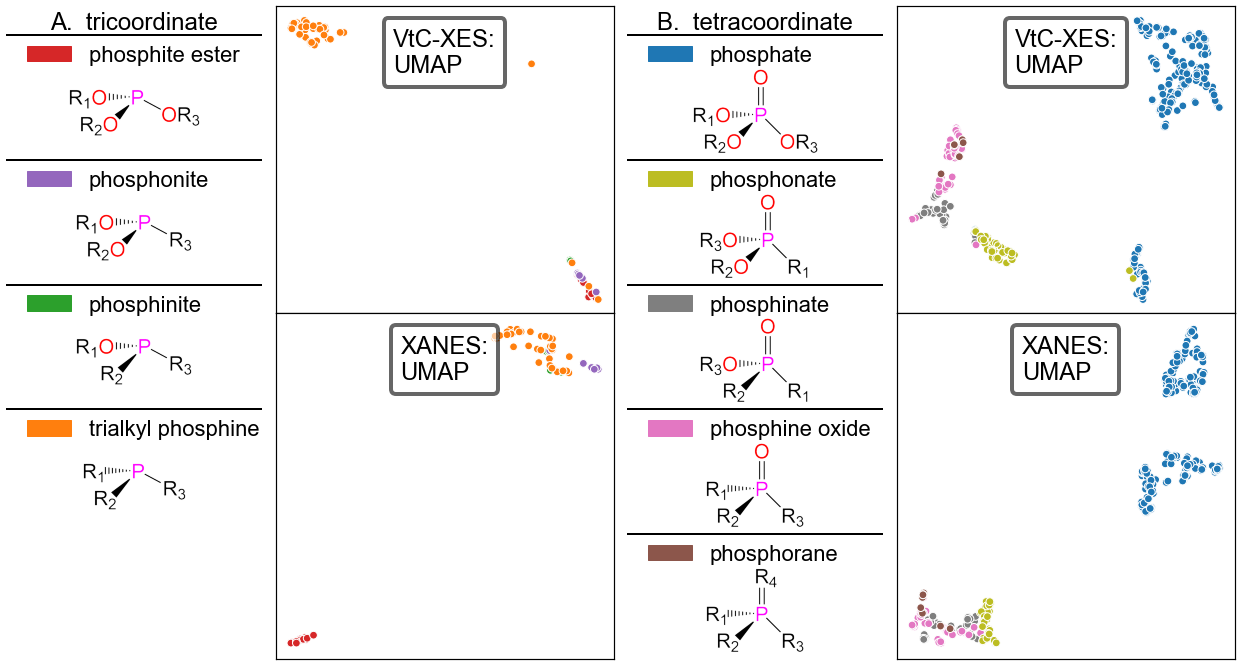

In [10]:
fig = plt.figure(figsize=(22,12))
asize = 0.3
spec = fig.add_gridspec(nrows=11, ncols=4,
                        width_ratios = [0.6, 0.8, 0.6, 0.8],
                        height_ratios=[asize, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
plt.subplots_adjust(wspace=0.05, hspace=0)

tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

structs = [tri_struct, tetra_struct]
labels = [tri, tetra]
titles = ['A.  tricoordinate', 'B.  tetracoordinate']

colorcode, codemap = CLASSCODES, classcodemap

for j, structure_list in enumerate(structs):
    for i, structure in enumerate(structure_list):
        # show structure
        structax = fig.add_subplot(spec[2*i + 2, 2*j])
        if j == 0:
            structure = resize_img(structure, ratio=(1,1.8))
        else:
            pass
        structax.imshow(structure)
        plt.axis('equal')
        turn_off_ticks(structax)
        set_spine_width(structax, width=2)
        turn_off_spines(structax, spines=['top','left','right'])
        if i == len(structure_list) - 1:
            structax.spines['bottom'].set_visible(False)
        
        # make legend
        legax = fig.add_subplot(spec[2*i + 1, 2*j])
        patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                  label=(labels[j][i].replace('_',' ')))]
        legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(0., 0.3),
                              fontsize=22, framealpha=0, frameon=False)
        turn_off_ticks(legax)
        set_spine_width(legax, width=2)
        turn_off_spines(legax, spines=['bottom','left','right'])
        
        if i == 0:
            legax.set_title(titles[j], fontsize=24)

for i, coordnum in enumerate([1, 3]):
    hiddencids = hiddenCIDS.copy()
    hiddencids += [cid for cid, coord in coordcodemap.items() if coord != coordnum]
    ax = fig.add_subplot(spec[:6, 2*i + 1])
    class_tsneplt = plot_dim_red((fig, ax), X_coord, XES_tsnemap, colorcodemap=codemap,
                                  mode='XES', method='UMAP', hiddencids=hiddencids, fontsize=24,
                                  size=60, edgecolors='w', hiddenalpha=0.0, **{'loc': 'upper center'})
    set_spine_width(ax, width=1.2)

    ax = fig.add_subplot(spec[6:11, 2*i + 1])
    class_tsneplt = plot_dim_red((fig, ax), X_coord, XANES_tsnemap, colorcodemap=codemap,
                                  mode='XANES', method='UMAP', hiddencids=hiddencids, fontsize=24,
                                  size=60, edgecolors='w', hiddenalpha=0.0, **{'loc': 'upper center'})
    set_spine_width(ax, width=1.2)
    
plt.savefig(f'../Figures/oxidation.png', dpi=1000, transparent=False, bbox_inches='tight')

# Spaghetti based on chemical classes (within coordination)

* How do tricoordinate versus tetracoordinate compare spectrally?

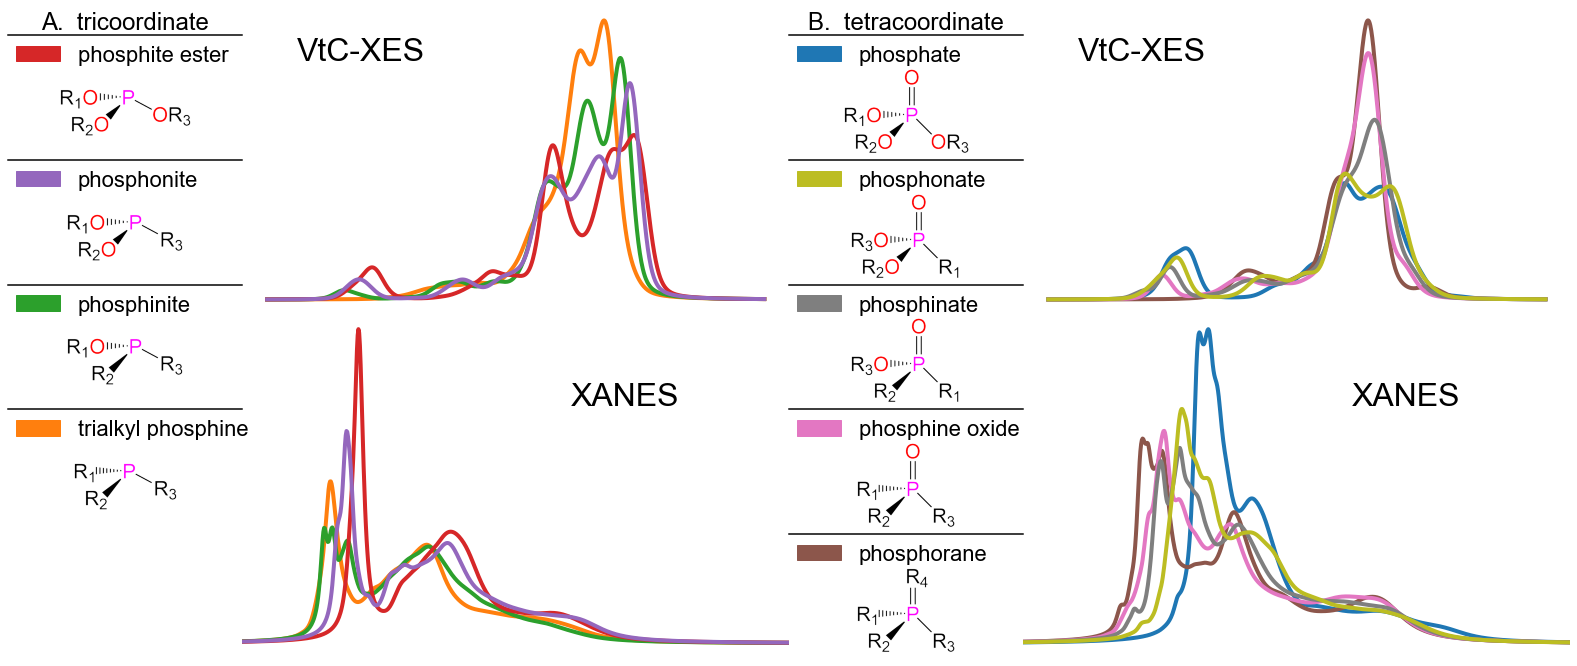

In [10]:
if make_SI_figures:
    fig = plt.figure(figsize=(28,12))
    asize = 0.3
    spec = fig.add_gridspec(nrows=11, ncols=4,
                            width_ratios = [0.3, 0.7, 0.3, 0.7],
                            height_ratios=[asize, asize, 1, asize, 1, asize, 1, asize, 1, asize, 1])
    plt.subplots_adjust(wspace=0, hspace=0)

    tri = ['phosphite_ester', 'phosphonite', 'phosphinite', 'trialkyl_phosphine']
    tri_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tri]

    tetra = ['phosphate', 'phosphonate', 'phosphinate', 'phosphine_oxide', 'phosphorane']
    tetra_struct = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in tetra]

    structs = [tri_struct, tetra_struct]
    labels = [tri, tetra]
    titles = ['A.  tricoordinate', 'B.  tetracoordinate']

    colorcode, codemap = CLASSCODES, classcodemap

    for j, structure_list in enumerate(structs):
        for i, structure in enumerate(structure_list):
            # show structure
            structax = fig.add_subplot(spec[2*i + 2, 2*j])
            if j == 0:
                structure = resize_img(structure, ratio=(1,1.8))
            else:
                pass
            structax.imshow(structure)
            structax.axis('equal')
            turn_off_ticks(structax)
            turn_off_spines(structax)

            # make legend
            legax = fig.add_subplot(spec[2*i + 1, 2*j])
            patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[j][i]] - 1),
                                      label=(labels[j][i].replace('_',' ')))]
            legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(-0.05, 0.3),
                                  fontsize=22, framealpha=0, frameon=False)
            turn_off_ticks(legax)
            turn_off_spines(legax, spines=['bottom','left','right'])
            set_spine_width(legax, width=1.5)

            if i == 0:
                legax.set_title(titles[j], fontsize=24)

    for i, coordnum in enumerate([1, 3]):
        hiddencids = hiddenCIDS.copy()
        hiddencids += [cid for cid, coord in coordcodemap.items() if coord != coordnum]

        binmap = {cid:v-1 for cid, v in classcodemap.items() if cid not in hiddencids}
        ax = fig.add_subplot(spec[:6, 2*i + 1])

        spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XES',
                                       colorcodemap=binmap, binmap=binmap,
                                       fontsize=26, linewidth=4, scalecolor=False,
                                       hiddenalpha=0, coloralpha=1.0, average_bins=True,
                                       verbose=False)

        ax = fig.add_subplot(spec[6:11, 2*i + 1])

        spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XANES',
                                       colorcodemap=binmap, binmap=binmap,
                                       fontsize=26, linewidth=4, scalecolor=False,
                                       hiddenalpha=0, coloralpha=1.0, average_bins=True,
                                       verbose=False, energyrange=(2142,2175))

    plt.savefig(f'../Figures/SI_oxidation_spaghetti.png', dpi=800, transparent=False, bbox_inches='tight')

## Sulfur-included bonding environment

* How does changing the ligand from carbon to sulfur impact the t-SNE clustering?

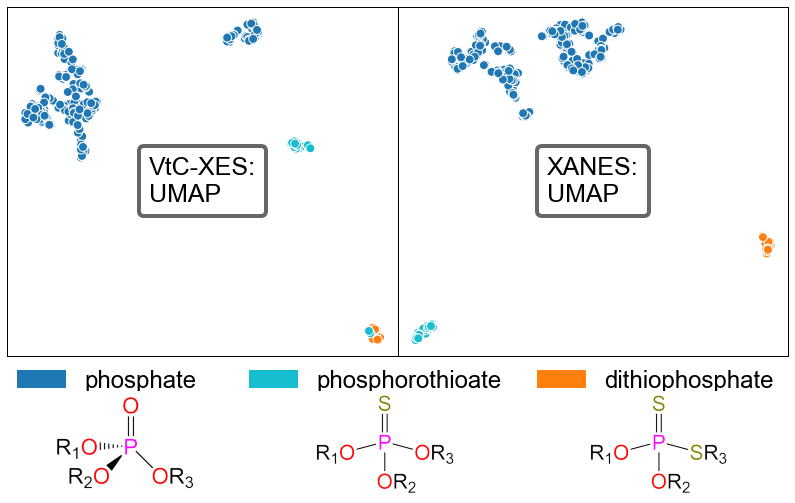

In [12]:
# sulfur subclasses
codemap = sulfurcodemap
labels = ['phosphate', 'phosphorothioate', 'dithiophosphate']
bin_names = list(SULFURCODES.keys())
N = len(labels)

fig = plt.figure(figsize=(14,9))
spec = fig.add_gridspec(nrows=3, ncols=6, width_ratios=[1, 0.8, 1.2, 1, 1, 1],
                        height_ratios=[1, 0.1, 0.3])
plt.subplots_adjust(wspace=0, hspace=0)

kwargs = {'Class': labels}

X_subset, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XES',
                                                              method='umap', **kwargs)
X_subset, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XANES',
                                                                  method='umap', **kwargs)

structures = [plt.imread(f'../Figures/chemdraw/{clsname}.png') for clsname in labels]

for i, structure in enumerate(structures):
    # make legend
    legax = fig.add_subplot(spec[1, 2*i:2*i + 2])
    patches = [mpatches.Patch(color=plt.cm.tab20(SULFURCODES[labels[i]] - 1),
                              label=(labels[i].replace('_',' ')))]
    legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(-0.05, 0.3),
                              fontsize=24, framealpha=0, frameon=False)
    turn_off_ticks(legax)
    turn_off_spines(legax)

    # show structure
    structax = fig.add_subplot(spec[2, 2*i:2*i + 2])
    structax.imshow(structures[i])
    turn_off_ticks(structax)
    turn_off_spines(structax)

for mode in ['XES', 'XANES']:
    if mode == 'XES':
        tsnemap = XES_tsnemap
        col1, col2 = 0, 3
        options = {'loc':'center'}
    else:
        tsnemap = XANES_tsnemap
        col1, col2 = 3, 6
        options = {'loc': 'center'}
    #################### tsne plot
    ax = fig.add_subplot(spec[0, col1:col2])
    tsne_plt = plot_dim_red((fig, ax), X_subset, tsnemap, size=80,
                            colorcodemap=codemap, coloralpha=1., hiddenalpha=0.03,
                            mode=mode, method='UMAP', fontsize=25, edgecolors='w',
                            **Merge(kwargs, options))
    set_spine_width(ax, width=1.)
    add_point_pubchem_link(tsne_plt, X_subset)
    
plt.savefig(f'../Figures/sulfur.png', dpi=1000, transparent=False, bbox_inches='tight')

## Phosphate subclusters

* Why are the phosphates being sub-divided into three different clusters?

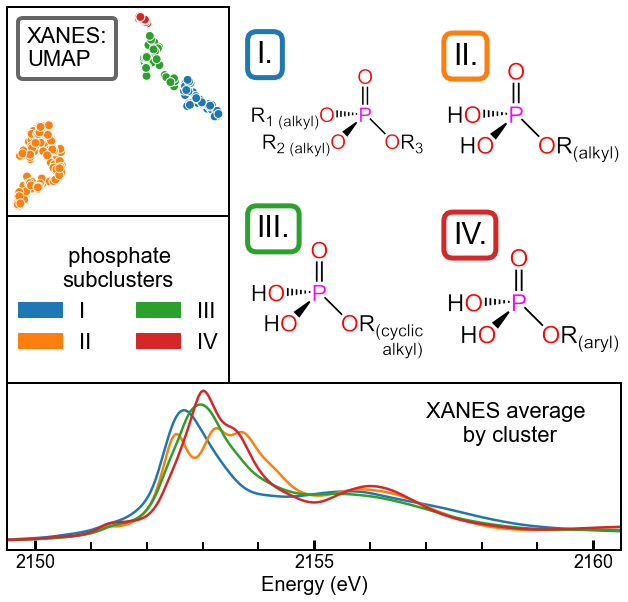

In [5]:
##### kwargs
kwargs = {'Class': ['phosphate'], 'loc': 'upper left', 'title': None}
mode = 'XANES'
filename = 'Testlists/phosphate_subcluster_map.txt'

# X_phosphate, redmap, redspace, _ = get_subset_maps(X_data_classed, classcodemap, mode=mode,
#                                                    method='umap', **kwargs)
# write_file_map(filename, redmap)

X_phosphate = [c for c in X_data_classed if c['Class'] in kwargs['Class']]
redmap = get_map_from_file(filename, test=False)
redspace = np.array(list(redmap.values()))

## make figure
fig = plt.figure(figsize=(11,10))
spec = fig.add_gridspec(nrows=3, ncols=3, width_ratios=[1.0, 0.8, 0.8], height_ratios=[1.0, 0.8, 0.8])
plt.subplots_adjust(wspace=0.1, hspace=0)

##  create DBScan clusters
cids_phosphates = [c['CID'] for c in X_phosphate]

dbscan_clustering = DBSCAN(eps=0.7, min_samples=1).fit(redspace)
dbscan_clustermap = {cid:cluster for cid,cluster in zip(cids_phosphates, dbscan_clustering.labels_)}

##  plot all phosphates with clusters indicated by DBSCAN
phosphate_clustermap = {c['CID']: dbscan_clustermap[c['CID']]*2 + 1 for c in X_phosphate}
select_clusters = np.unique(dbscan_clustering.labels_) + 1
keys = {1:'I', 2:'II', 3:'III', 4:'IV', 5:'V', 6:'VI', 7:'VII'}

############# legend
legax = fig.add_subplot(spec[1, 0])
patches = [mpatches.Patch(color=plt.cm.tab20(2*(cluster - 1)), label=keys[cluster])
           for cluster in select_clusters]
legend = legax.legend(handles=patches, loc='center', bbox_to_anchor=(0.5, 0.5),
                      fontsize=22, framealpha=0, frameon=False, ncol=2,
                      title=' phosphate\nsubclusters', title_fontsize=22)
# format frame
set_spine_width(legax, width=2)
turn_off_ticks(legax)

############# corner plot with everything
subax = fig.add_subplot(spec[0, 0])
size = 80
corner_plt = plot_dim_red((fig, subax), X_phosphate, redmap, size=size,
                          colorcodemap=phosphate_clustermap, hiddenalpha=0.05,
                          mode=mode, method='UMAP', fontsize=22, show_legend=True,
                          edgecolors='w', **kwargs)
set_spine_width(subax, width=2)
turn_off_ticks(subax)

add_point_pubchem_link(corner_plt, X_phosphate)

############ spaghetti plot of average clusters indicated by DBSCAN
ax = fig.add_subplot(spec[2, :])
if mode == 'XANES':
    energyrange = (2149.5,2160.5)
else:
    energyrange = None
colorcodemap = {k: v - 1 for k, v in phosphate_clustermap.items()}
spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode=mode,
                               colorcodemap=colorcodemap, binmap=colorcodemap, fontsize=26,
                               linewidth=2.5, energyrange=energyrange, scalecolor=False,
                               hiddenalpha=0, coloralpha=1.0, average_bins=True,
                               **kwargs)
label = ax.text(2157, 0.28, f'XANES average\n      by cluster', ha="left", va="center", size=22)
# formatting frame
set_spine_width(ax, width=2)
ax.set_yticks([])
ax.tick_params(direction='in', width=3, length=10, which='major', labelsize=18)
ax.tick_params(direction='in', width=2, length=8, which='minor')
ax.set_xlabel('Energy (eV)', fontsize=20)

# add cluster structures
for cluster, pair in enumerate([(0, 1), (0, 2), (1, 1), (1, 2)]):
    i, j = pair
    ax = fig.add_subplot(spec[i, j])
    img = Image.open(f"../Figures/chemdraw/{keys[cluster + 1]}.png")
    width, height = img.size[0], img.size[1]
    if cluster == 1:
        bias = 50
    elif cluster == 4:
        bias = 100
    else:
        bias = 0
    label = ax.text(width*0.05, height*0.05 + bias, f'{keys[cluster + 1]}.', ha="left", va="bottom", size=30,
                    bbox=dict(boxstyle="round,pad=0.3", ec=plt.cm.tab20(2*cluster), fc="w", lw=5))
    ax.imshow(img)
    ax.axis('off')
    
plt.savefig(f'../Figures/phosphate_subclusters.png', dpi=1000, transparent=False, bbox_inches='tight')

In [14]:
cids = []
for cid, cluster in dbscan_clustermap.items():
    if cluster + 1 == 3:
        if compoundmap[cid]['Charge'] != -1:
            cids += [cid]
print(cids)

[59, 121947, 2115, 11988266, 729, 13869, 466, 123912, 11242708, 15066, 127766, 107737]


## Correlation analysis

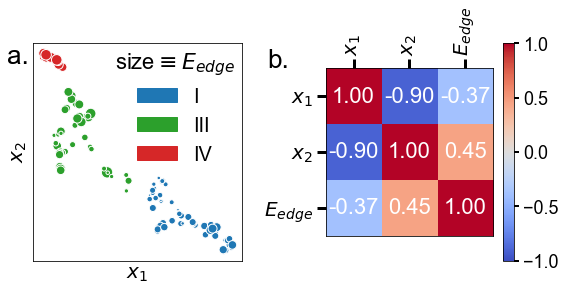

In [335]:
dismiss = 3
energy = X_phosphate[0]['XANES_Spectra'][0]
whiteline = np.array([energy[np.argmax(np.gradient(c['XANES_Normalized']))] for c in X_phosphate 
                 if phosphate_clustermap[c['CID']] != dismiss ])

size = whiteline - min(whiteline)
size = size/max(size)
size = size*130

colors = np.array([plt.cm.tab20(col-1) for col in list(phosphate_clustermap.values())
                  if col != dismiss])
subset = np.array([redmap[c['CID']] for c in X_phosphate 
                  if phosphate_clustermap[c['CID']] != dismiss ])
cid_sub = np.array([c['CID'] for c in X_phosphate if phosphate_clustermap[c['CID']] != dismiss ])

data = pd.DataFrame(np.array([subset.T[0], subset.T[1], whiteline]).T,
                    columns=['$x_1$', '$x_2$', '$E_{edge}$'], index=cid_sub)
corr = data.corr()

fig, axes = plt.subplots(figsize=(9, 4), nrows=1, ncols=2)
plt.subplots_adjust(wspace=0.4)

axes[0].scatter(subset[:,0], subset[:,1], s=size, c=colors, edgecolors='w')
turn_off_ticks(axes[0])
axes[0].set_xlabel('$x_1$', fontsize=20)
axes[0].set_ylabel('$x_2$', fontsize=20)

patches = [mpatches.Patch(color=plt.cm.tab20(2*(cluster - 1)), label=keys[cluster])
           for cluster in [1,3,4]]
legend = axes[0].legend(handles=patches, loc='upper right', bbox_to_anchor=(1.05, 1.05),
                        fontsize=20, framealpha=0, frameon=False, 
                        title='size$\equiv E_{edge}$', title_fontsize=22)


cax = axes[1].matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
for (i, j), z in np.ndenumerate(corr):
    axes[1].text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            fontsize=22, color='w')

cbar = fig.colorbar(cax)
cbar.ax.tick_params(labelsize=18)
cbar.ax.tick_params(width=2, length=5)
axes[1].tick_params(width=3, length=9, bottom=False)
ticks = np.arange(0,len(data.columns),1)
axes[1].set_xticks(ticks)
plt.xticks(rotation=90)
axes[1].set_yticks(ticks)
axes[1].set_xticklabels(data.columns, fontsize=20)
axes[1].set_yticklabels(data.columns, fontsize=20)

axes[0].text(5.3, 9.93, 'a.', ha='left', va='top', fontsize=26)
axes[1].text(-1.55, -0.85, 'b.', ha='left', va='top', fontsize=26)

plt.savefig(f'../Figures/SI_correlation.png', dpi=1000, transparent=False, bbox_inches='tight')

### Generate examples

[[  62773  439871 6107844   21804  119401]
 [   3039    6535   17280    4420   81525]]
[[ 3034794   439452   439276    74188   439162]
 [    1055     1051 21896400      561 45934311]]
[[      59   160886     7925   439278    83430]
 [  440043    99058 44610740 45487828    65533]]
[[    2526     1005    15391 12241336  3246323]
 [14299674      378     3418 12241338    12793]]


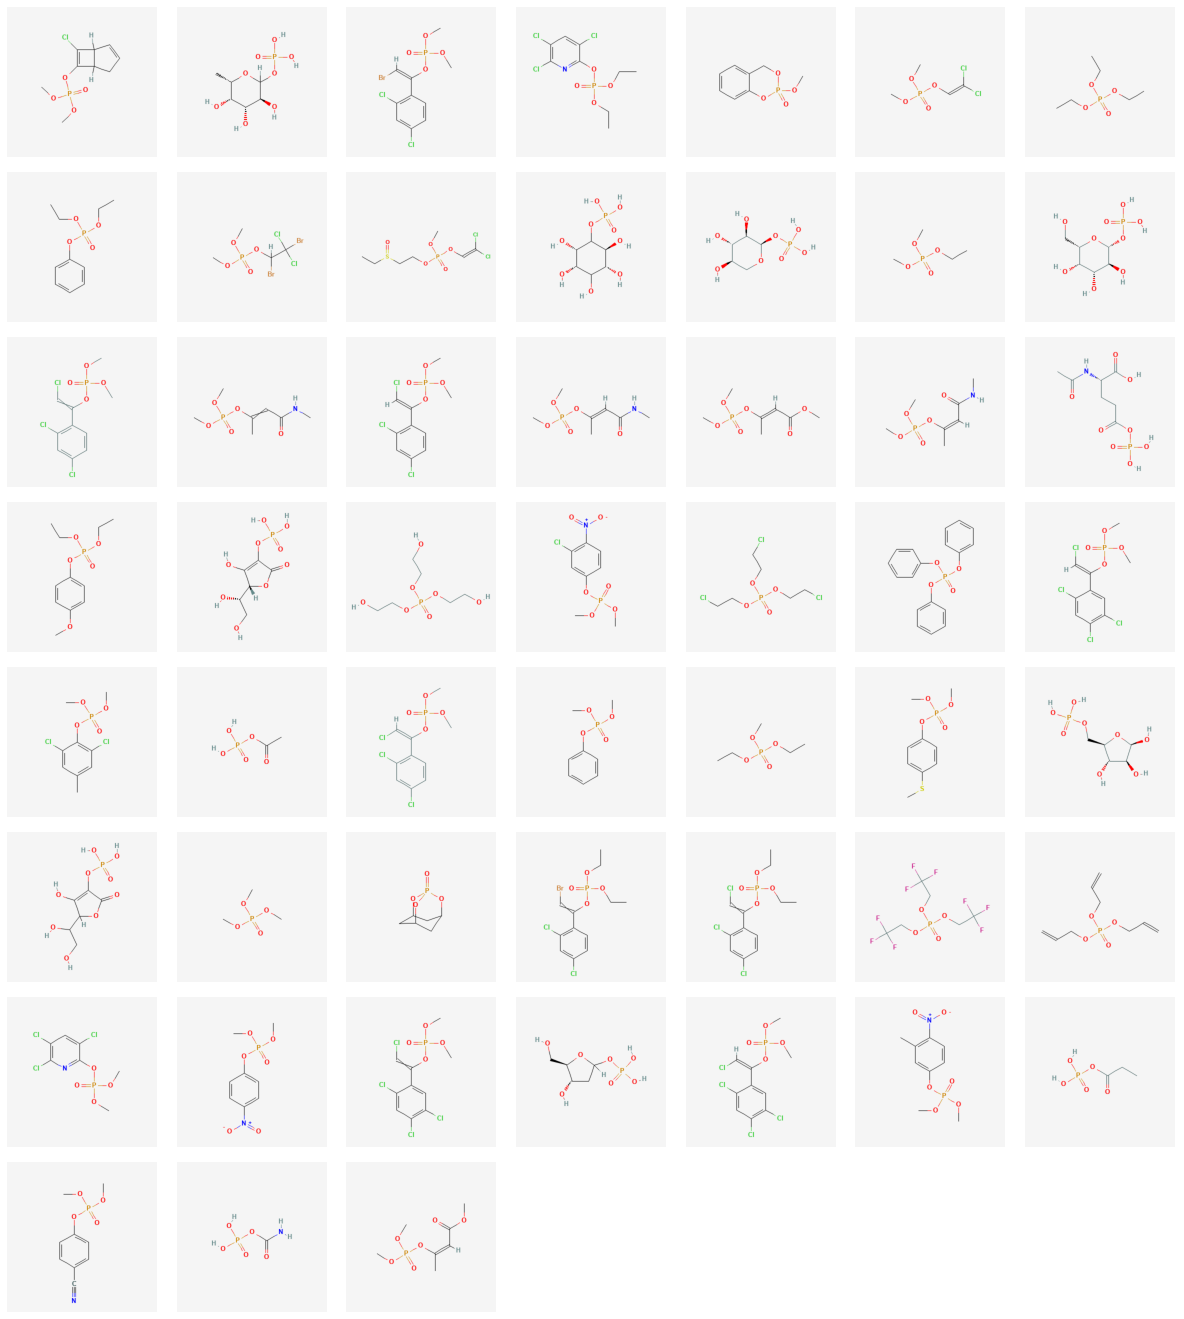

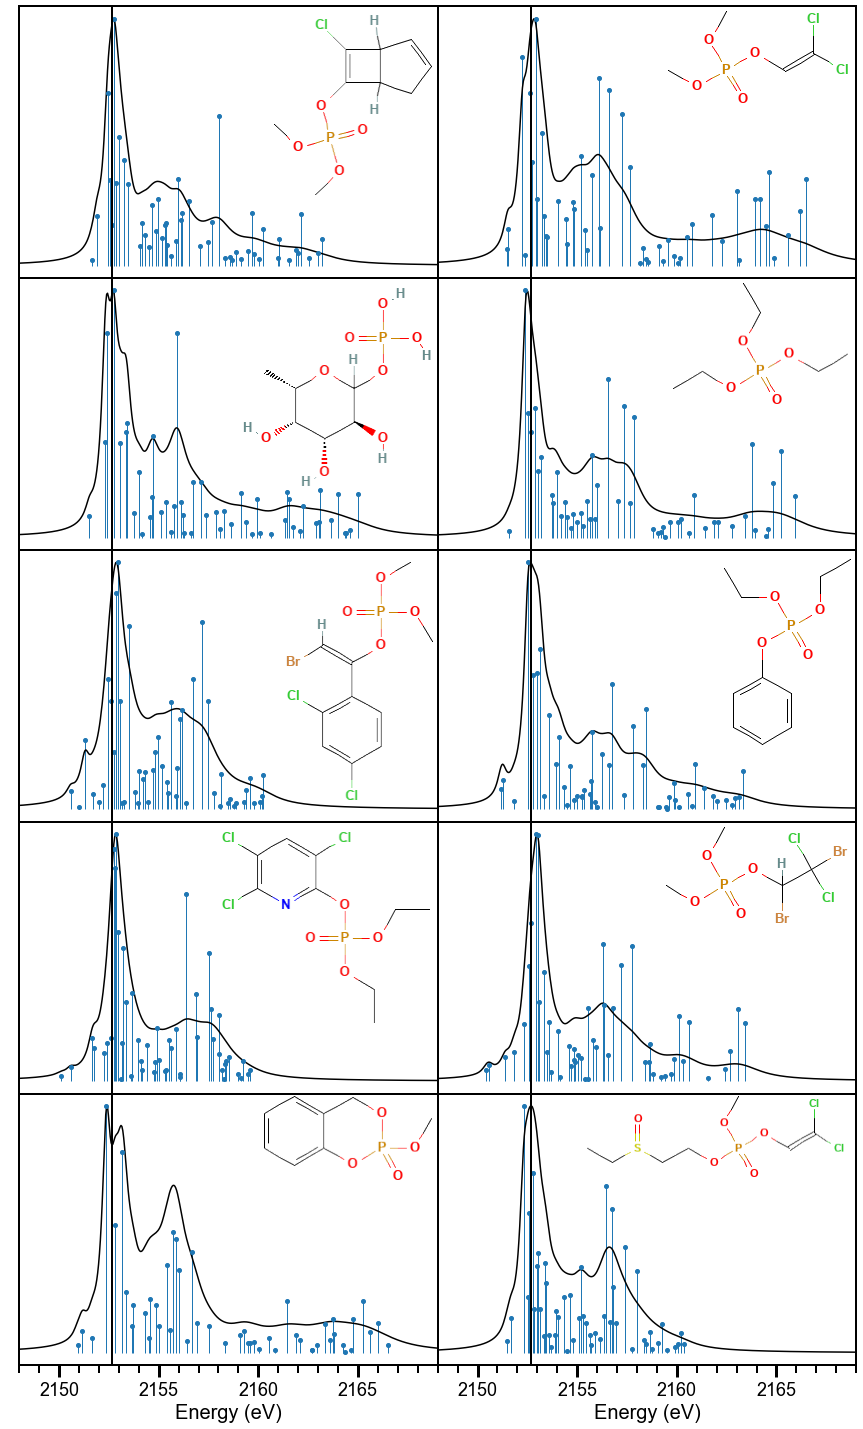

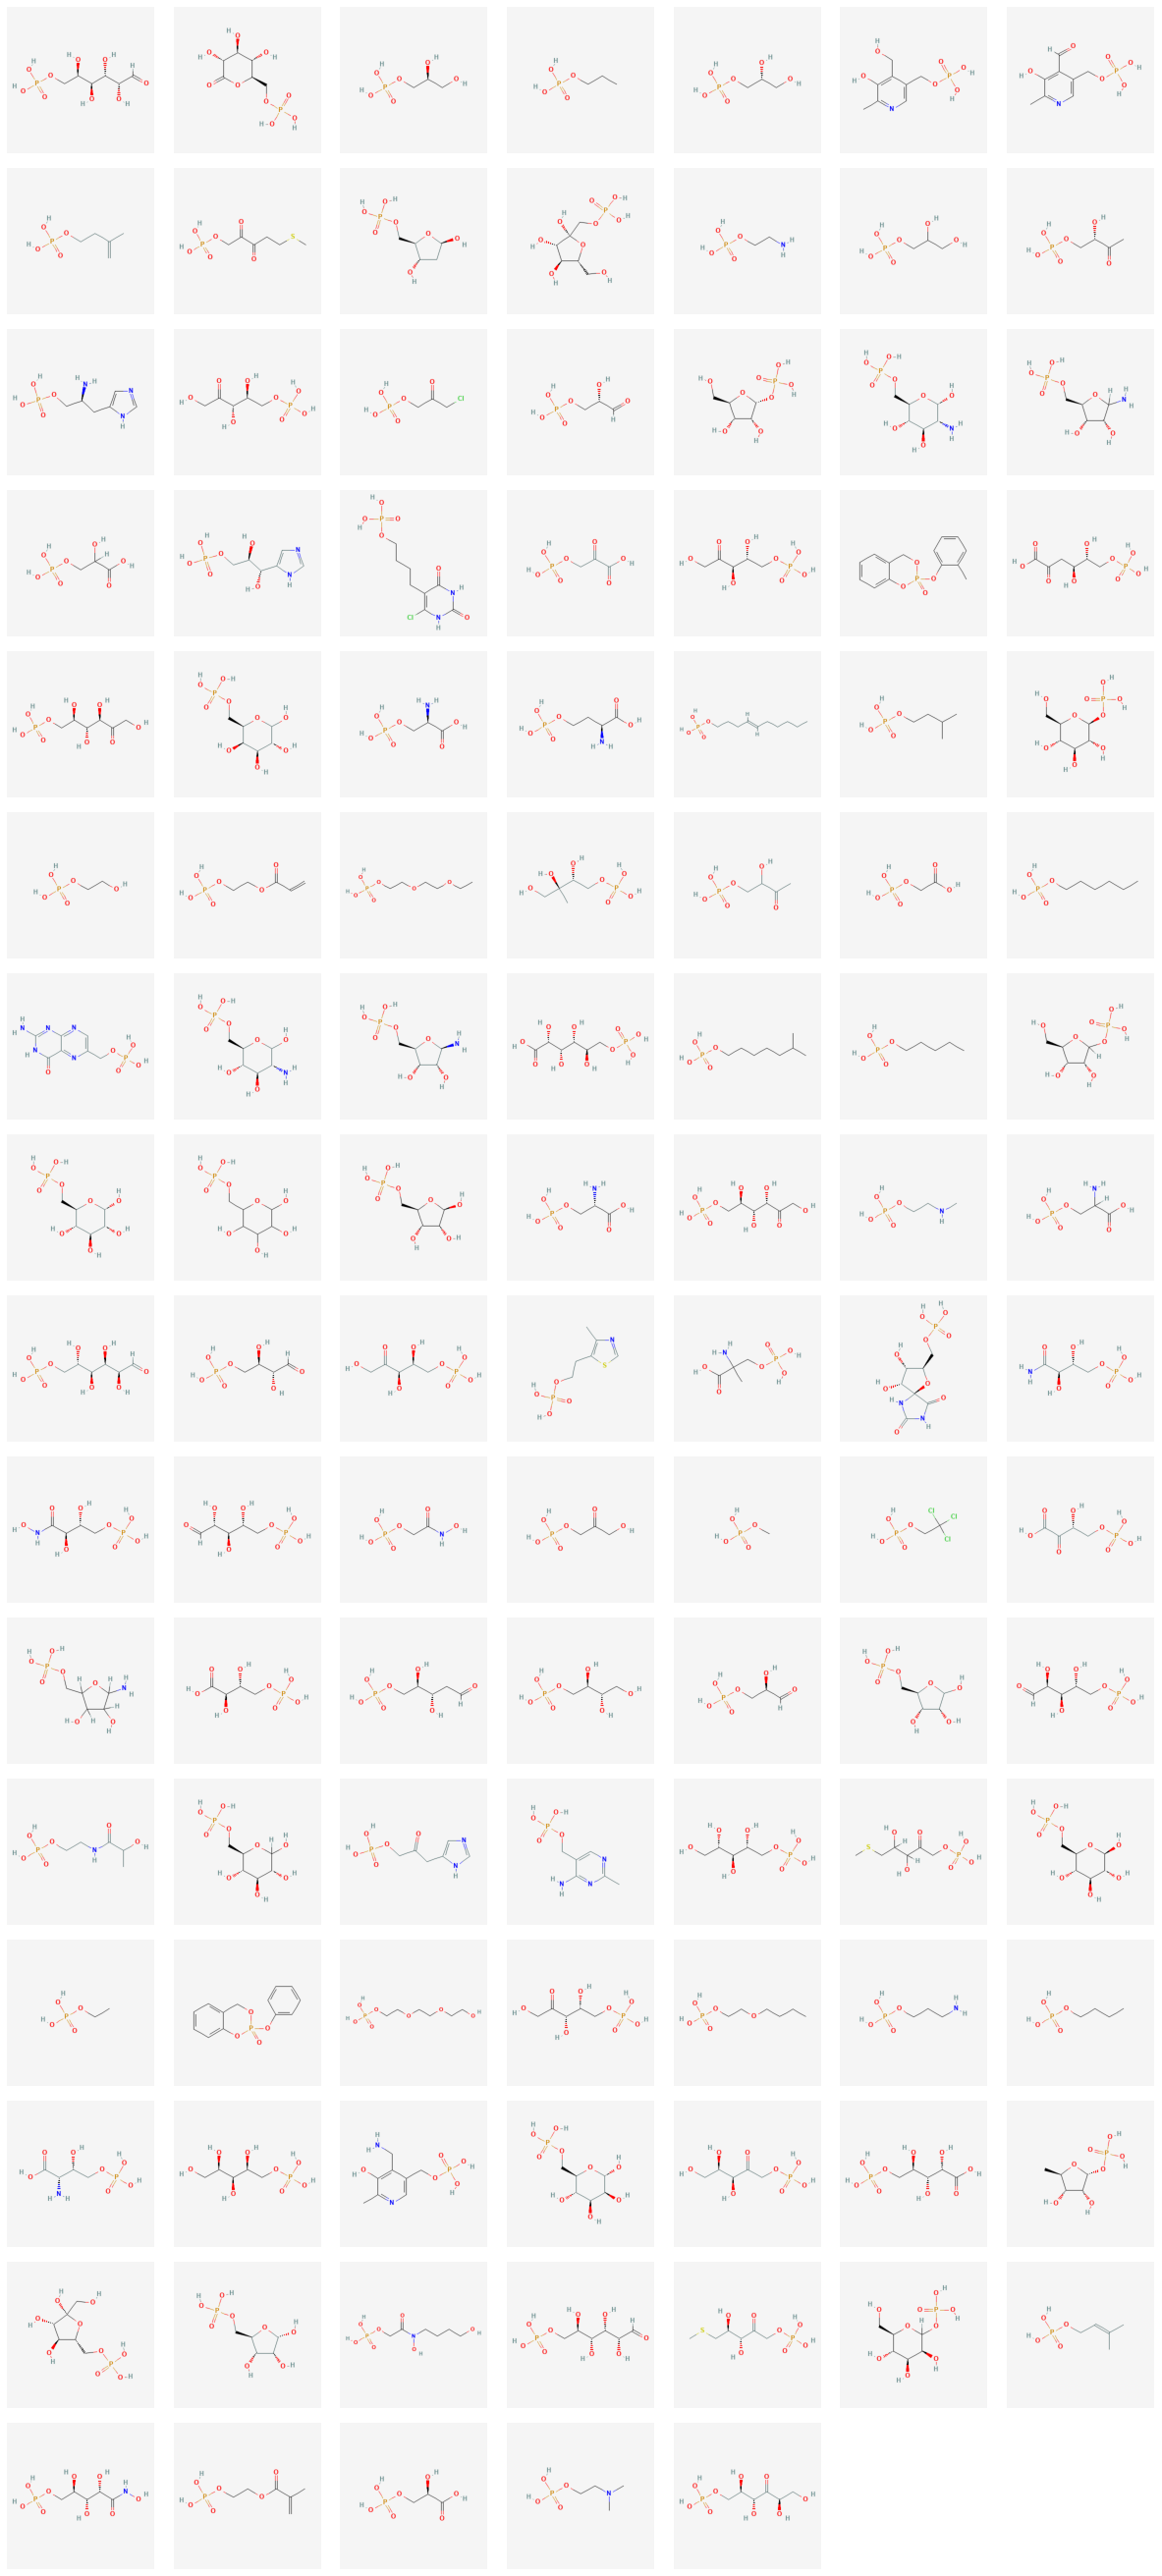

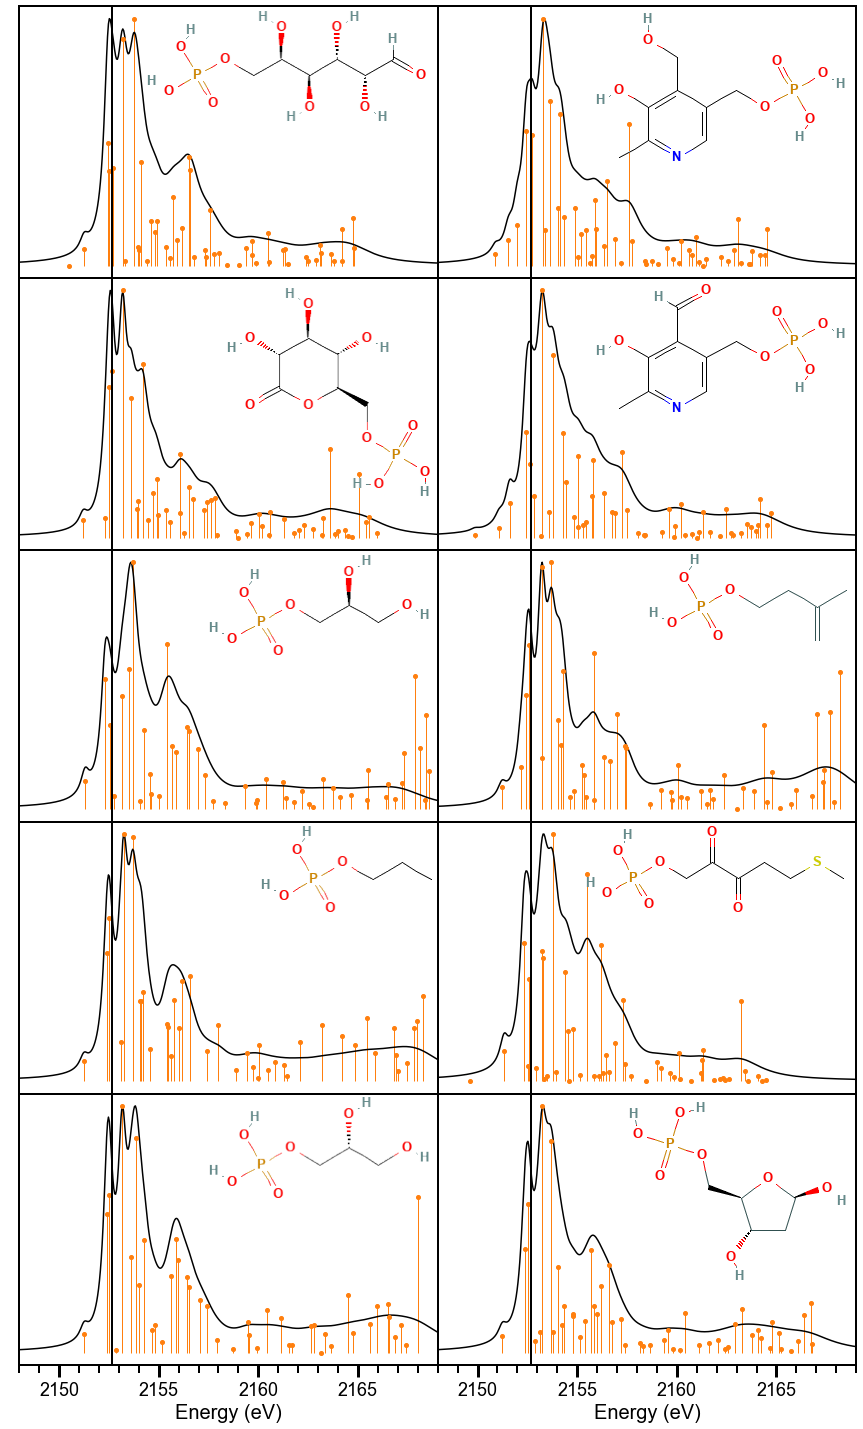

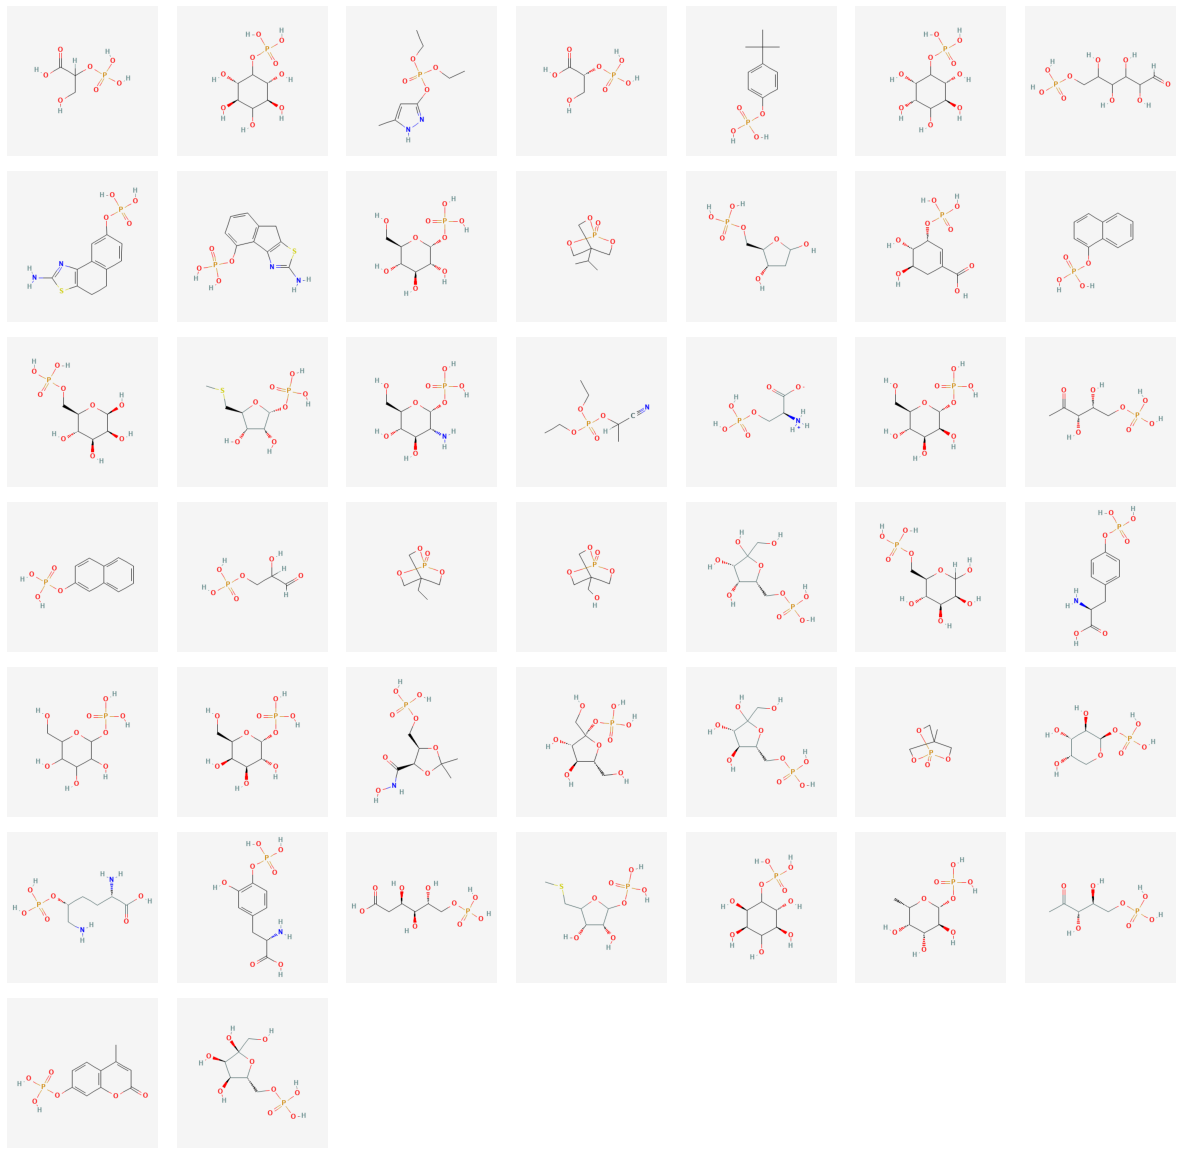

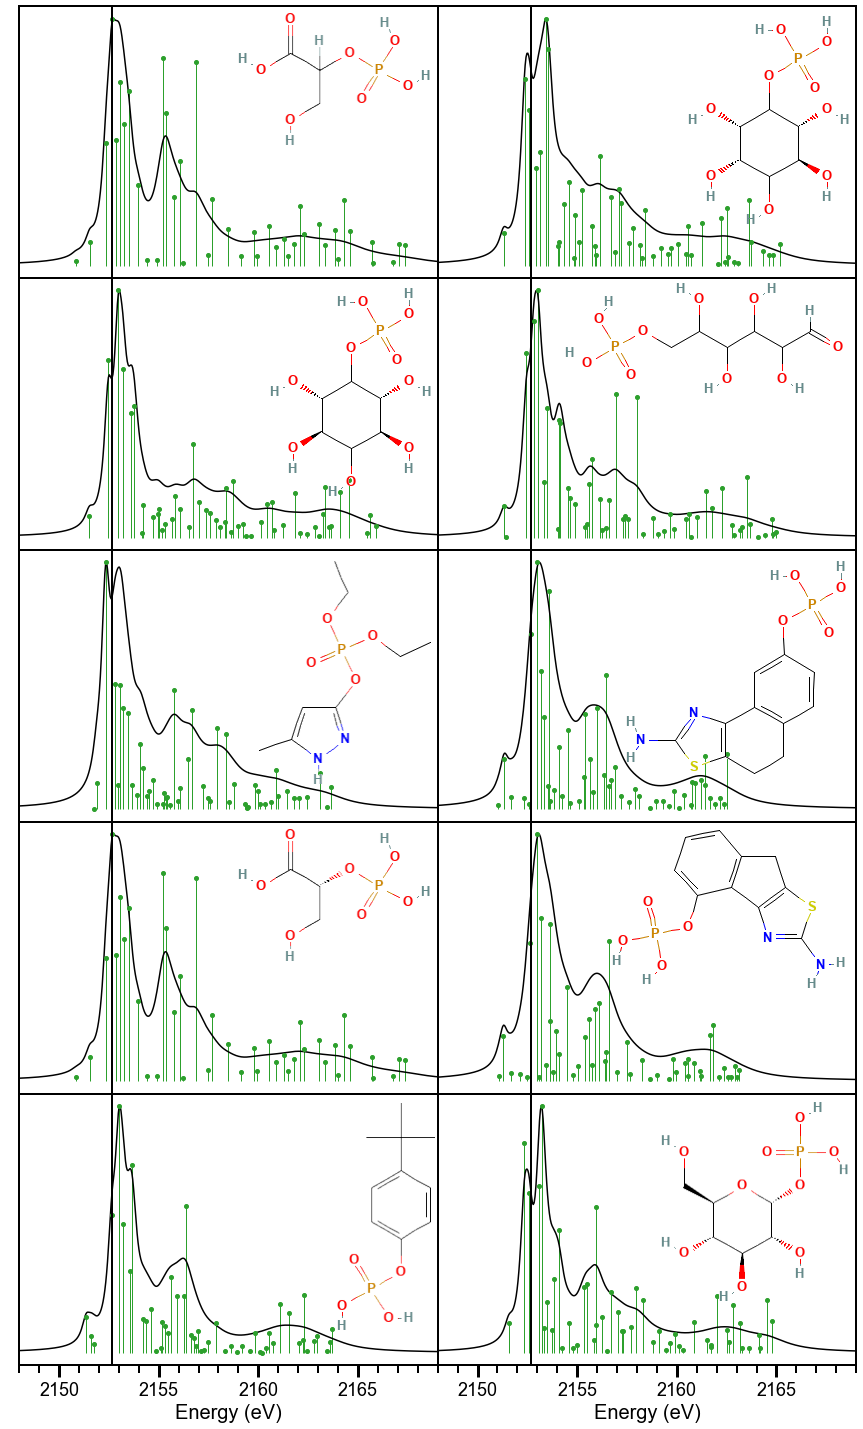

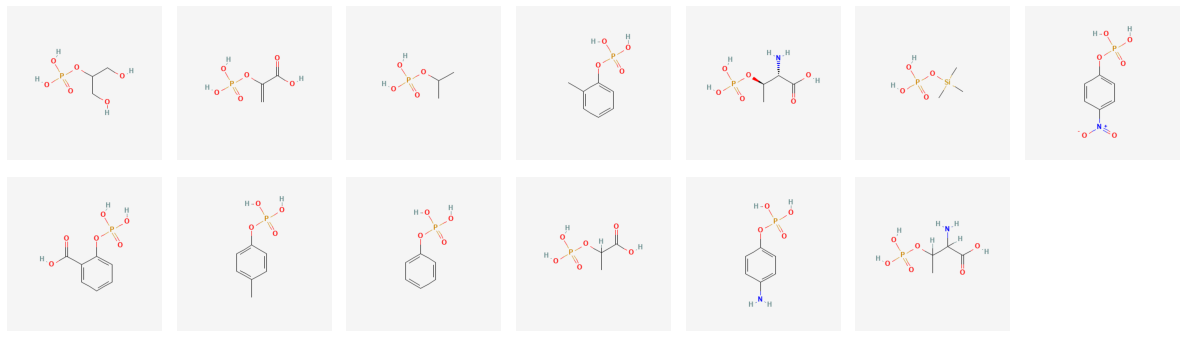

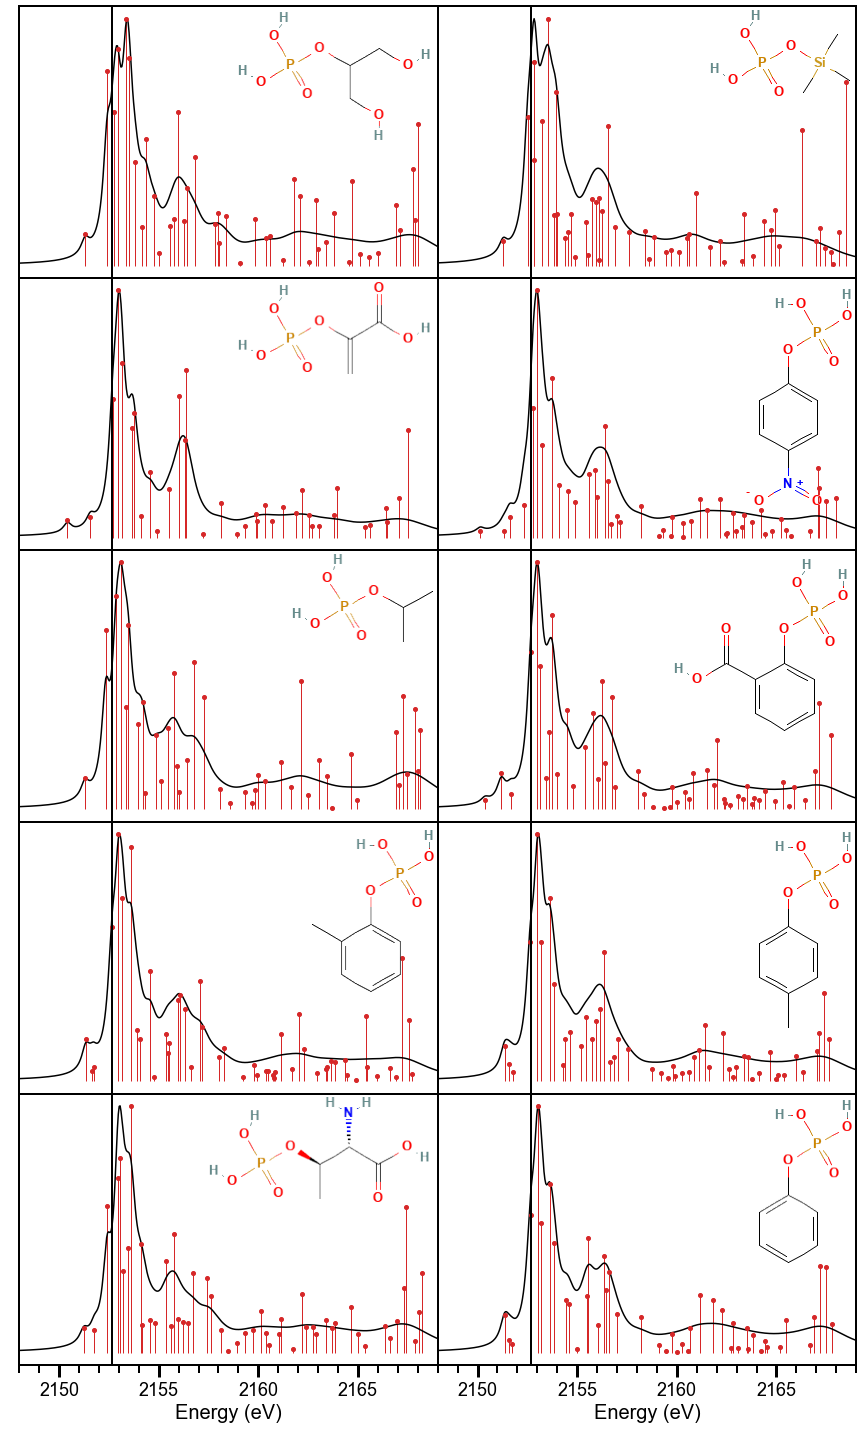

In [336]:
if make_SI_figures:
    for select in select_clusters:
        cids = []
        for cid, cluster in dbscan_clustermap.items():
            if cluster + 1 == select:
                cids += [cid]
                
        # show every structure for each compound
        N = len(cids)
        if N < 7:
            ncols = 2
        else:
            ncols = 7
        nrows = N//ncols + 1
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        for i in range(int(ncols*nrows)):
            row, colm = np.unravel_index(i, (nrows, ncols))
            axes[row, colm].axis('off')
            if i < N:
                cid = cids[i]
                urllib.request.urlretrieve(f"https://pubchem.ncbi.nlm.nih.gov/image/imgsrv.fcgi?cid={cid}&t=l",
                                       f"../Figures/pubchem_structures/{cid}.png")
                img = Image.open(f"../Figures/pubchem_structures/{cid}.png")
                axes[row, colm].imshow(img)               
        plt.savefig(f'../Figures/SI_phosphate_cluster_{keys[select]}_structures.png',
                    dpi=800, bbox_inches='tight')
                
        
        ### make spectra figure
        if len(cids) < 10:
            N = len(cids)//2
        else:
            N = 5
        cids = np.array(cids[:N*2]).reshape((2,N))
        print(cids)

        fig, axes = plt.subplots(nrows=N, ncols=2, figsize=(15,N*5))
        plt.subplots_adjust(wspace=0, hspace=0)

        for colm, cid_list in enumerate(cids):
            for i, cid in enumerate(cid_list):
                if i == N-1:
                    verbose = True
                else:
                    verbose = False
                plot_spectrum_and_trans((fig, axes[i, colm]), compoundmap, cid, verbose=verbose,
                                        mode='XANES', energyrange=(2148,2169), color=2*(select - 1),
                                        link_pubchem=True, chemdraw=False, resize=True)
                set_spine_width(axes[i, colm], width=2)
        plt.savefig(f'../Figures/SI_phosphate_cluster_{keys[select]}_spectra.png', dpi=800, bbox_inches='tight')

### Charge analysis

In [13]:
# if make_SI_figures:
#     coord_to_charge_map = {}
#     cids = []
#     for i in range(len(X_phosphate)):
#         cid = X_phosphate[i]['CID']
#         data = parse_esp_file(cid)
#         if data is not None:
#             cids.append(cid)
#             coord_to_charge_map[cid] = data

#     cid = cids[0]
#     print(cid)
#     fig = plt.figure()
#     ax = fig.add_subplot(projection='3d')
#     points, colors, sizes, labels = get_plot_data(coord_to_charge_map[cid])
#     dots = ax.scatter(*zip(*points), s=sizes, c=colors, label=labels)
#     ax.set_title(cid, fontsize=20)
#     add_charge_label(dots, coord_to_charge_map[cid])

#     make_charge_hist(plt.subplots(figsize=(12,6)), oxygen_chargemap,
#                      colorcodemap=phosphate_clustermap,
#                      bins=25, atom='O', fontsize=20)
#     plt.savefig(f'../Figures/SI_O_charge_hist.png', dpi=800, bbox_inches='tight')

# OH group dependence

* How do hydroxyls, i.e., an H instead of a C, impact the spectra?

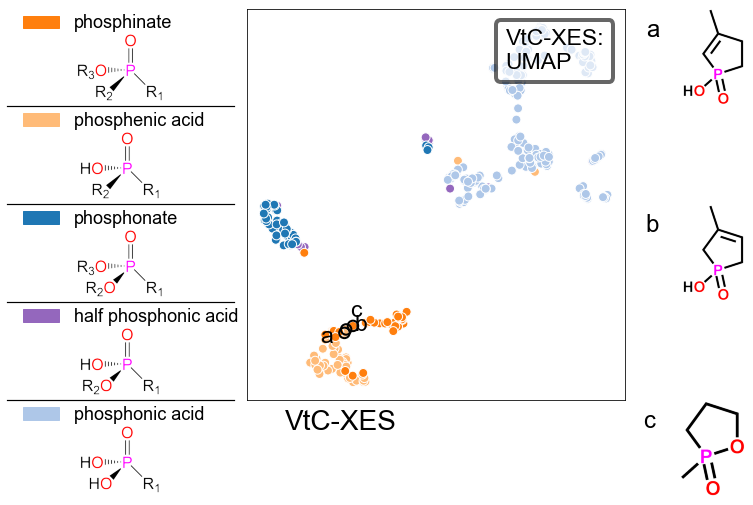

In [14]:
labels = ['phosphinate', 'phosphenic_acid', 'phosphonate', 'half_phosphonic_acid', 'phosphonic_acid']
structures = [Image.open(f'../Figures/chemdraw/{clsname}.png') for clsname in labels]
colorcode, codemap = OHCODES, ohcodemap
N = len(labels)

method = 'UMAP'

########## set up figure with axes
fig = plt.figure(figsize=(14, 9))
ratio = 0.3
spec = fig.add_gridspec(nrows=N*2, ncols=3, width_ratios=[0.6, 1, 0.4],
                        height_ratios=[ratio, 1, ratio, 1, ratio, 1, ratio, 1, ratio, 1])
plt.subplots_adjust(wspace=0.05, hspace=0)

########## set up formatting kwargs and variables
kwargs = {'Class': labels, 'loc':1, 'title': ''}

########## get reuced spaces with corresponding maps
X_subset, XES_tsnemap, XES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XES',
                                                              method=method, **kwargs)
X_subset, XANES_tsnemap, XANES_TSNE, hiddenCIDS = get_subset_maps(X_data_classed, codemap, mode='XANES',
                                                                  method=method, **kwargs)
cid_subset = [c['CID'] for c in X_data_classed if c['Class'] in labels]

########## make first column with structures
for i, structure in enumerate(structures):
    # show structure
    structax = fig.add_subplot(spec[2*i+1,0])
    structax.imshow(structures[i])
    structax.axis('equal')
    # Hide spines
    turn_off_spines(structax)
    turn_off_ticks(structax)
        
    # make legend
    legax = fig.add_subplot(spec[2*i,0])
    patches = [mpatches.Patch(color=plt.cm.tab20(colorcode[labels[i]] - 1),
                              label=(labels[i].replace('_',' ')))]
    legend = legax.legend(handles=patches, loc='center left', bbox_to_anchor=(0., 0.35),
                          fontsize=18, framealpha=0, frameon=False)
    # Hide spines
    set_spine_width(legax, width=1.2)
    turn_off_spines(legax, spines=['bottom','left','right'])
    if i == 0:
        turn_off_spines(legax, spines=['top'])
    turn_off_ticks(legax)
    
########### set-up example settings
select_cids = [98611, 21720419, 104467]
label = ['a', 'b', 'c']
colorcodemap = {98611:0.1, 21720419:0.5, 104467:0.7} 
offsets = [(-18, -14), (15, -5), (3, 5)]
energyrange = (2119, 2142)
tsnemap = XES_tsnemap   

###### spaghetti plot of selected cids
ax = fig.add_subplot(spec[N*2-2:, 1])
spaghetti_plt = plot_spaghetti((fig, ax), compoundmap, mode='XES', scalecolor=False,
                                colorcodemap=colorcodemap, colormap=plt.cm.viridis,
                                linewidth=2.5, hiddenalpha=0, coloralpha=1.0, verbose=False,
                                energyrange=energyrange, **Merge(kwargs, options))

###### drawing arrow and annotating
x, y, dx, dy = 2132.5, 1.18, 1.8, -0.13
arr = mpl.patches.Arrow(x, y, dx, dy, width=0.04, linestyle='-',
                        edgecolor='k', facecolor='k', zorder=5)
ax.add_patch(arr)
ax.annotate('a', (x, y), ha='center', va='bottom',
            size=24, xytext=(-10, 2), textcoords='offset points')
ax.annotate('c', (x + dx, y + dy), ha='center', va='bottom',
            size=24, xytext=(10, -10), textcoords='offset points')

######## select options for the 2D plot
options = Merge(kwargs, {'CID': select_cids, 'offsets':offsets, 'label':label})
subax = fig.add_subplot(spec[:N*2-2, 1])
            
#################### tsne plot   
tsne_plt = plot_dim_red((fig, subax), X_subset, tsnemap, size=80, 
                        colorcodemap=codemap, coloralpha=1., hiddenalpha=0.03,
                        mode='XES', method=method, fontsize=23, edgecolors='w',
                        large_ticks=False, **options)

##### show selected cid structures
for i, cid in enumerate(select_cids):
    size = 2
    structax = fig.add_subplot(spec[size*i*2: size*i*2 + size, 2])
    img = Image.open(f"../Figures/chemdraw/{cid}.png")
    structax.imshow(img)
    structax.axis('off')
    structax.annotate(label[i], (0, 0), ha='right', va='top',
                      size=24, xytext=(-0.35, 0.9), textcoords='axes fraction')
        
plt.savefig(f'../Figures/{method}_OH.png', dpi=1000, transparent=False, bbox_inches='tight')

# 3D Spaces

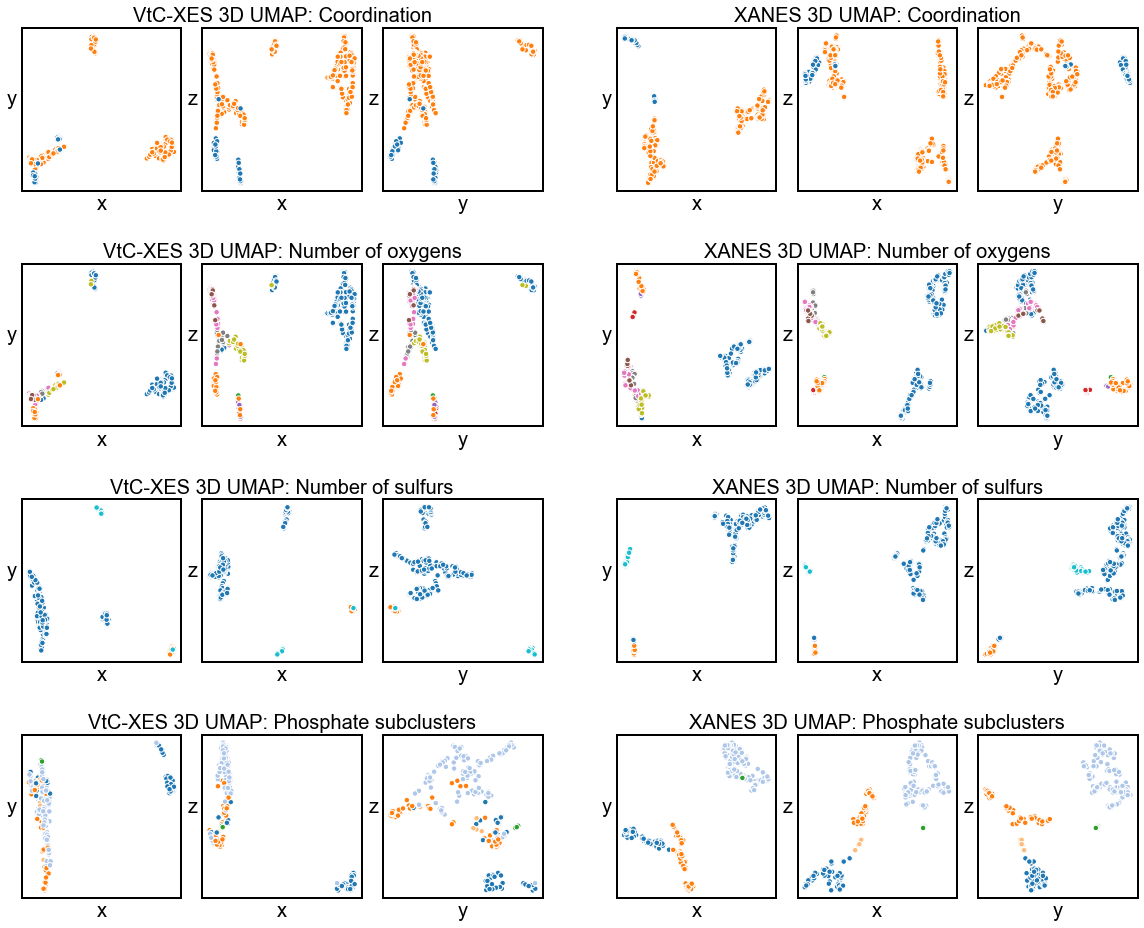

In [128]:
fig = plt.figure(figsize=(20, 16))
spec = fig.add_gridspec(nrows=4, ncols=7,
                        width_ratios=[1,1,1,0.2,1,1,1])
plt.subplots_adjust(wspace=0.15, hspace=0.45)
row = 0

for colorcodemap, scheme in [[coordcodemap, 'Coordination'],
                             [classcodemap, 'Number of oxygens'],
                             [sulfurcodemap, 'Number of sulfurs'],
                             [phosphate_clustermap, 'Phosphate subclusters']]:
    
    for mode in ['XES', 'XANES']:
        
        X_subset, redspacemap, reduced_space, hiddencids = get_subset_maps(X_data_classed, colorcodemap, mode=mode,
                                                                           method='UMAP', ndim=3)
        colors = [colorbynumber(colorcodemap[compound['CID']])
                      if compound['CID'] not in hiddencids
                      else (0, 0, 0, 0.3) for compound in X_subset]
        points = np.array([redspacemap[compound['CID']] for compound in X_subset])

        index_to_axis_map = {0: 'x', 1: 'y', 2: 'z'}
        if mode == 'XES':
            mode = 'VtC-' + mode
            base = 0
        else:
            base = 4

        for dim, pair in enumerate([(0, 1), (0, 2), (1, 2)]):
            ax = fig.add_subplot(spec[row, base + dim])
            i, j = pair
            ax.scatter(points[:,i], points[:, j], s=30, c=colors, edgecolors='w')
            set_spine_width(ax, width=2.)
            turn_off_ticks(ax)
            ax.set_xlabel(index_to_axis_map[i], fontsize=20)
            ax.set_ylabel(index_to_axis_map[j] + '  ', fontsize=20, rotation=0)
            
            if dim == 1:
                ax.set_title(f'{mode} 3D UMAP: {scheme}', fontsize=20)

    row += 1

plt.savefig(f'../Figures/SI_3D_all.png', dpi=800, transparent=False, bbox_inches='tight')

# Supervised ML Visualization

In [16]:
# coordination
real_coord_map = {1: 3, 3: 4} # from color to coord number
real_coordination_codemap = {c['CID']:real_coord_map[coordcodemap[c['CID']]] for c in X_coord}

In [18]:
# write_test_file(phosphate_clustermap, 'Testlists/phosphate_test_cids.txt')
# write_test_file(real_coordination_codemap, 'Testlists/coord_test_cids.txt')
# write_test_file(classcodemap, 'Testlists/oxy_test_cids.txt')
# write_test_file(sulfurcodemap, 'Testlists/sulfur_test_cids.txt')
# write_test_file(ohcodemap, 'Testlists/OH_test_cids.txt')

In [24]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel

# ndim = 7

# model = GaussianProcessClassifier()
# cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=42)
# grid = dict()
# grid['kernel'] = [RationalQuadratic(),
#                   RBF(), 
#                   Matern()]
# search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# ####
# Schemes = ['Coordination', 'Oxygens', 'Phosphates', 'Sulfur ligand', 'Hydroxyl ligand']
# codemaps = [real_coordination_codemap, classcodemap, phosphate_clustermap,
#             sulfurcodemap, ohcodemap]
# test_files = ['coord_test_cids.txt', 'oxy_test_cids.txt', 'phosphate_test_cids.txt',
#               'sulfur_test_cids.txt', 'OH_test_cids.txt']
# CODEMAPS = [COORDCODES, CLASSCODES, {'phosphate':1}, SULFURCODES, OHCODES]
# kwargs = {'method': 'UMAP', 'ndim': 5}
# ###

# for codemap, test_file, scheme, CODES in zip(codemaps, test_files, Schemes, CODEMAPS):
#     for mode in ['XES', 'XANES']:
#         print(f"\n{mode}: {scheme}")
#         test_map = get_map_from_file(f'Testlists/{test_file}')
#         kwargs['codemap'] = codemap
#         kwargs['Class'] = list(CODES.keys())
#         train_map = get_train_map(codemap, test_map)
        
#         ### from  train GP
#         X_train = [c for c in X_data if c['CID'] in list(train_map.keys())]
#         X_test = [c for c in X_data if c['CID'] in list(test_map.keys())]
#         args = {'Class': kwargs['Class']}
#         pca_reducer, trained_reducer = get_subset_maps(X_train, kwargs['codemap'],
#                                                        mode=mode, method=kwargs['method'],
#                                                        return_reducer=True,
#                                                        ndim=kwargs['ndim'],
#                                                        **args)
#         training_args = {'X_train': X_train, 'X_test': X_test,
#                          'pca_reducer': pca_reducer, 'mode': mode,
#                          'trained_reducer': trained_reducer}
#         xtrain, xval, xtest, ytrain, yval, ytest = get_ML_datasets(train_map,
#                                                                    test_map,
#                                                                    **training_args)
#         ## begin print block
#         results = search.fit(xtrain, ytrain)
#         print('Best Mean Accuracy: %.3f' % results.best_score_)
#         print('Best Config: %s' % results.best_params_)
#         means = results.cv_results_['mean_test_score']
#         params = results.cv_results_['params']
#         for mean, param in zip(means, params):
#             print(">%.3f with: %r" % (mean, param))
#         print('--------------------')

In [23]:
Accuracies = [[], []]
Confidence = [[], []]

Schemes = ['Coordination', 'Oxygens', 'Phosphates', 'Sulfur ligand', 'Hydroxyl ligand']
codemaps = [real_coordination_codemap, classcodemap, phosphate_clustermap,
            sulfurcodemap, ohcodemap]
test_files = ['coord_test_cids.txt', 'oxy_test_cids.txt', 'phosphate_test_cids.txt',
              'sulfur_test_cids.txt', 'OH_test_cids.txt']
CODEMAPS = [COORDCODES, CLASSCODES, {'phosphate':1}, SULFURCODES, OHCODES]

kwargs = {'method': 'UMAP', 'ndim': 5}

for codemap, test_file, scheme, CODES in zip(codemaps, test_files, Schemes, CODEMAPS):
    test_map = get_map_from_file(f'Testlists/{test_file}', test=True)
    kwargs['codemap'] = codemap
    kwargs['Class'] = list(CODES.keys())
    train_map = get_train_map(codemap, test_map)
    train_GP(X_data_classed, train_map, test_map, Accuracies=Accuracies,
             Confidence=Confidence, validate=False, **kwargs)

C:\Users\saman\Downloads\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:418: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


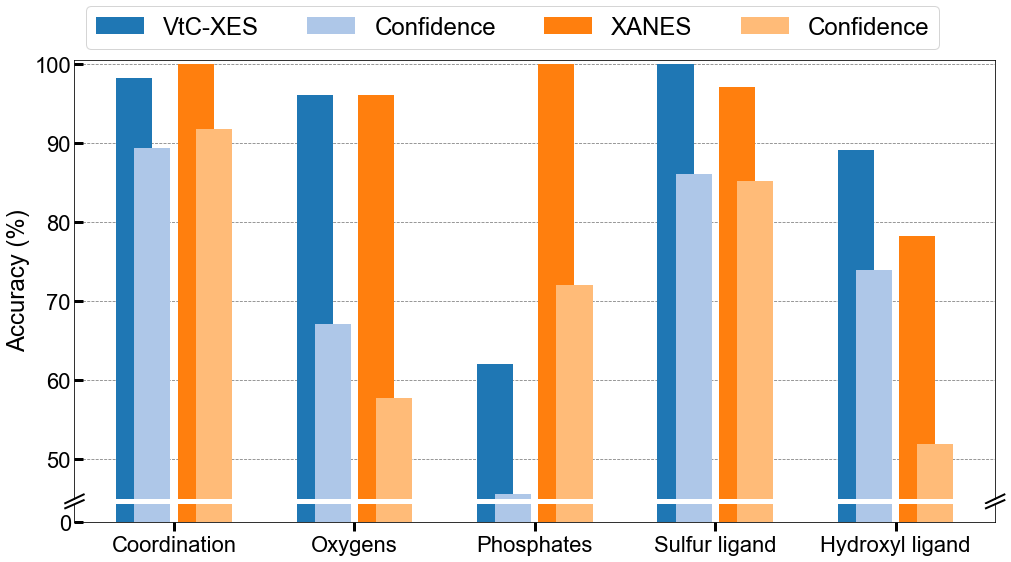

In [25]:
bar_chart(Accuracies, Confidence, Schemes, save=True)